<a href="https://colab.research.google.com/github/Vaani64/Apache_Spark_Workshop/blob/main/the_MNIST_Denoising_Autoencoder_with_RBM_Pretraining_and_Stacked_RBM_Model_for_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


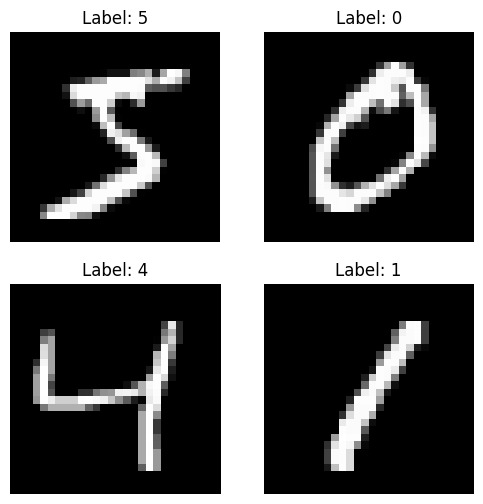

Shape of reshaped training data: (60000, 784)
Shape of reshaped test data: (10000, 784)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the model...
Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0717 - val_loss: 0.0186
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0169 - val_loss: 0.0127
Making predictions...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Original Test Images


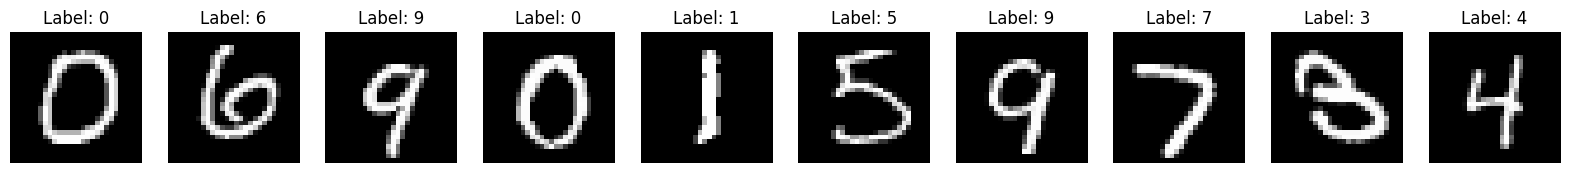

Noisy Test Images


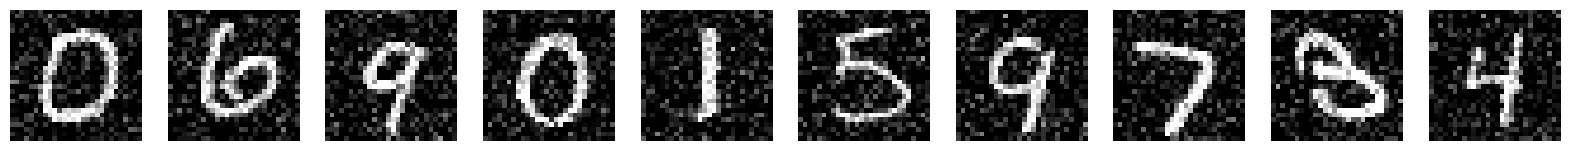

Denoised Images


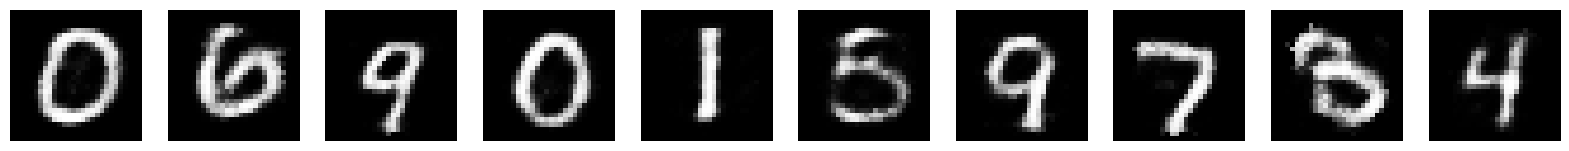

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist

# Loading the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Check the shape of the dataset
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Visualize the first few images in the training dataset
plt.figure(figsize=(6,6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

# Reshape and normalize the data
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32') / 255

print(f"Shape of reshaped training data: {X_train.shape}")
print(f"Shape of reshaped test data: {X_test.shape}")

# Add noise to the dataset
noise_factor = 0.2
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# Clip the noisy data to ensure values are between 0 and 1
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

# Define the autoencoder model
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(num_pixels,)))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(784, activation='sigmoid'))  # 784 corresponds to 28x28 image pixels

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
print("Training the model...")
model.fit(X_train_noisy, X_train, validation_data=(X_test_noisy, X_test), epochs=2, batch_size=200)

# Make predictions (denoised images)
print("Making predictions...")
pred = model.predict(X_test_noisy)

# Reshape images back to 28x28
X_test = np.reshape(X_test, (-1, 28, 28)) * 255
pred = np.reshape(pred, (-1, 28, 28)) * 255
X_test_noisy = np.reshape(X_test_noisy, (-1, 28, 28)) * 255

# Plot original test images
plt.figure(figsize=(20, 4))
print("Original Test Images")
for i in range(10, 20):
    plt.subplot(2, 10, i - 9)
    plt.imshow(X_test[i, :, :], cmap='gray')
    curr_lbl = y_test[i]
    plt.title(f"Label: {curr_lbl}")
    plt.axis('off')
plt.show()

# Plot noisy test images
plt.figure(figsize=(20, 4))
print("Noisy Test Images")
for i in range(10, 20):
    plt.subplot(2, 10, i - 9)
    plt.imshow(X_test_noisy[i, :, :], cmap='gray')
    plt.axis('off')
plt.show()

# Plot denoised (reconstructed) images
plt.figure(figsize=(20, 4))
print("Denoised Images")
for i in range(10, 20):
    plt.subplot(2, 10, i - 9)
    plt.imshow(pred[i, :, :], cmap='gray')
    plt.axis('off')
plt.show()


In [5]:
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Function to generate synthetic binary data
def generate_data(samples=1000, features=50):
    np.random.seed(42)
    X = np.random.rand(samples, features) > 0.5
    y = (np.sum(X, axis=1) > (features / 2)).astype(int)  # Simple rule: sum of features > half the total features
    return X, y

class StackedRBMs:
    def __init__(self, rbm_layers, rbm_learning_rate=0.1, rbm_n_iter=10):
        self.rbms = [
            BernoulliRBM(n_components=n_components, learning_rate=rbm_learning_rate, n_iter=rbm_n_iter)
            for n_components in rbm_layers
        ]
        self.logistic_regression = LogisticRegression()

    def pretrain(self, X):
        # Pretrain each RBM layer in a stacked manner
        for i, rbm in enumerate(self.rbms):
            if i == 0:
                rbm.fit(X)  # Train the first RBM
                X = rbm.transform(X)  # Get the hidden representation
            else:
                rbm.fit(X)  # Train the next RBM
                X = rbm.transform(X)  # Get the hidden representation

    def finetune(self, X, y):
        # Fine-tune the stacked representation with logistic regression
        X_transformed = X
        for rbm in self.rbms:
            X_transformed = rbm.transform(X_transformed)  # Apply all RBM layers

        # Train a logistic regression model on the top of the RBM features
        self.logistic_regression.fit(X_transformed, y)

    def predict(self, X):
        # Get the transformed features from all RBM layers
        X_transformed = X
        for rbm in self.rbms:
            X_transformed = rbm.transform(X_transformed)

        # Predict using logistic regression
        return self.logistic_regression.predict(X_transformed)

if __name__ == "__main__":
    # Generate synthetic data
    X, y = generate_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define RBM stacking parameters (number of hidden units per RBM layer)
    rbm_layers = [128, 64]  # two RBMs with 128 and 64 hidden units respectively

    # Initialize and pretrain the stacked RBM
    stacked_rbm = StackedRBMs(rbm_layers=rbm_layers, rbm_learning_rate=0.05, rbm_n_iter=15)

    # Pretraining (unsupervised learning using RBMs)
    stacked_rbm.pretrain(X_train)

    # Fine-tuning (supervised learning using logistic regression)
    stacked_rbm.finetune(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = stacked_rbm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Print the test accuracy
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 85.00%
